In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/deeplearning-alterationzones

/content/drive/MyDrive/deeplearning-alterationzones


In [ ]:
!ls 

 Alteration_Zones.ipynb		        main.py
 ASTER_DATA_CNN_RMSPROP.csv	       'Mapped Files'
 Best_model_ASTER_DATA_CNN_RMSPROP      models
 Best_model_LANDSAT8_DATA_CNN_RMSPROP   output_prediction.py
 Data				        __pycache__
 Datasets			        README.md
 Data_tt			        references
 Graphs				        Results-10Experimental-Mean.csv
 hptuning.py			        Results-10Experimental-Std.csv
 Image_preprocessing.py		        results_df.csv
 LANDSAT8_DATA_CNN_RMSPROP.csv


In [ ]:
!pip install pyrsgis
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#from Image_preprocessing import multiclass_preprocess
import time
import random
import numpy as np
import tensorflow as tf
from numpy import asarray
from numpy import save
from keras import backend as K
from numpy import load
import pandas as pd
import seaborn as sns
from pyrsgis import raster
from pyrsgis.ml import array_to_chips   #imagechipsfromarray doesnt work anymore.
from math import floor
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc



##Multiclass_preprocess class of Image_preprocessing for preprocessing the datasets.

In [3]:
# class multiclass_preprocess:

#     def __init__(self, feature_file, positivelabel_file):
#         self.feature_file =  feature_file
#         self.positivelabel_file = positivelabel_file

#     def read_and_normalise_input(self):
#         # Reading and normalizing input data
#         dsFeatures, arrFeatures = raster.read(self.feature_file, bands='all')
#         # arrFeatures = arrFeatures.astype(float)
#         arrFeatures = np.float16(arrFeatures)

#         for i in range(arrFeatures.shape[0]):
#             bandMin = arrFeatures[i][:][:].min()
#             bandMax = arrFeatures[i][:][:].max()
#             bandRange = bandMax-bandMin
#             for j in range(arrFeatures.shape[1]):
#                 for k in range(arrFeatures.shape[2]):
#                     arrFeatures[i][j][k] = (arrFeatures[i][j][k]-bandMin)/bandRange

#         # Creating chips using pyrsgis
#         features = array_to_chips(arrFeatures, x_size=7, y_size=7)

#         return features

#     def read_and_normalise_labels(self):
#         # Reading and reshaping the label file
#         dsPositive, positiveLabels = raster.read(self.positivelabel_file)

#         # Generating random samples
#         nonZero_count = 0

#         for i in range(positiveLabels.shape[0]):
#             for j in range(positiveLabels.shape[1]):
#                 if positiveLabels[i,j] != 0:
#                     nonZero_count += 1

#         k = 0
#         index = np.zeros(((positiveLabels.shape[0]*positiveLabels.shape[1])-nonZero_count,2))

#         #Appending all the coordinates of points with zero labels in the index array
#         for i in range(positiveLabels.shape[0]):
#             for j in range(positiveLabels.shape[1]):
#                 if positiveLabels[i,j] == 0:
#                     index[k,0] = i
#                     index[k,1] = j
#                     k += 1

#         #Random Index of nonZero_count/2 coordinates from index
#         randomIndex = random.sample(range(index.shape[0]), floor(nonZero_count/2))
#         negativeLabels = np.zeros(positiveLabels.shape)

#         index = index.astype(int)

#         for i in range(len(randomIndex)):
#             negativeLabels[index[randomIndex[i],0],index[randomIndex[i],1]] = np.max(positiveLabels)+1

#         del index


#         positiveLabels = positiveLabels.flatten()
#         negativeLabels = negativeLabels.flatten()

#         features = self.read_and_normalise_input()
#         # Separating and balancing the classes
#         positiveFeatures = features[positiveLabels!=0]
#         positiveLabels = positiveLabels[positiveLabels!=0]

#         negativeFeatures = features[negativeLabels==np.max(positiveLabels)+1]
#         negativeLabels = negativeLabels[negativeLabels==np.max(positiveLabels)+1]

#         # Combining the balanced features
#         features = np.concatenate((positiveFeatures, negativeFeatures), axis=0)
#         labels = np.concatenate((positiveLabels, negativeLabels), axis=0)

#         del positiveFeatures
#         del negativeFeatures
#         del positiveLabels
#         del negativeLabels

#         return features, labels

#     # Defining the function to split features and labels
#     def train_test_split(self, trainProp=0.75):
#         features, labels = self.read_and_normalise_labels()
#         dataSize = features.shape[0]
#         sliceIndex = int(dataSize*trainProp)
#         randIndex = np.arange(dataSize)
#         random.shuffle(randIndex)
#         train_x = features[[randIndex[:sliceIndex]], :, :, :][0]
#         test_x = features[[randIndex[sliceIndex:]], :, :, :][0]
#         train_y = labels[randIndex[:sliceIndex]]
#         test_y = labels[randIndex[sliceIndex:]]

#         return(train_x, train_y, test_x, test_y)



In [ ]:
# ############# All the preprocessing of the image has been done in the image_preprocessing.py file ##############
# multiclass_preprocess_instance = multiclass_preprocess(feature_file, positiveLabel_file)
# train_x, train_y, test_x, test_y = multiclass_preprocess_instance.train_test_split()

# # save numpy array as csv file

# save('train_x.npy', train_x)
# save('train_y.npy', train_y)
# save('test_x.npy', test_x)
# save('test_y.npy', test_y)

## Loading the already preprocessed data

In [ ]:
def get_data(NAME):
  train_x = load('Data_tt/{}/train_x.npy'.format(NAME))
  train_y = load('Data_tt/{}/train_y.npy'.format(NAME))
  # validation_x = load('Data/{}/validation_x.npy'.format(NAME))
  # validation_y = load('Data/{}/validation_y.npy'.format(NAME))
  test_x = load('Data_tt/{}/test_x.npy'.format(NAME))
  test_y = load('Data_tt/{}/test_y.npy'.format(NAME))
  return train_x, train_y, test_x, test_y

In [ ]:
import pandas as pd
results_df = pd.read_csv("results_df.csv")

## Experimentation with Oversampling and Undersampling Techniques due to imbalanced datasets.

In [ ]:
# reshaped_train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1]*train_x.shape[2]*train_x.shape[3]))
# reshaped_test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1]*test_x.shape[2]*test_x.shape[3]))

# # define undersample strategy
# undersample = RandomUnderSampler()
# train_x_undersampled, train_y_undersampled = undersample.fit_resample(reshaped_train_x, train_y)
# train_x_undersampled = np.reshape(train_x_undersampled, (train_x_undersampled.shape[0], train_x.shape[1], train_x.shape[2], train_x.shape[3]))

# test_x_undersampled, test_y_undersampled = undersample.fit_resample(reshaped_test_x, test_y)
# test_x_undersampled = np.reshape(test_x_undersampled, (test_x_undersampled.shape[0], test_x.shape[1], test_x.shape[2], test_x.shape[3]))

# #define oversample strategy
# oversample = RandomOverSampler()
# train_x_oversampled, train_y_oversampled = oversample.fit_resample(reshaped_train_x, train_y)
# train_x_oversampled = np.reshape(train_x_oversampled, (train_x_oversampled.shape[0], train_x.shape[1], train_x.shape[2], train_x.shape[3]))

# test_x_oversampled, test_y_oversampled = oversample.fit_resample(reshaped_test_x, test_y)
# test_x_oversampled = np.reshape(test_x_oversampled, (test_x_oversampled.shape[0], test_x.shape[1], test_x.shape[2], test_x.shape[3]))

## Addtional Functions

In [ ]:
def plot_metric(history, metric):    #For plotting any graph relating to any model
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [ ]:
#Function to collect the results on the test data
def results(model, test_x, test_y):
  y_pred = model.predict(test_x, batch_size=64, verbose=1)
  # y_pred_final = np.empty_like(test_y)
  # j = 0
  # for i in y_pred:
  #   max_index = np.where(i == max(i))[0] 
  #   y_pred_final[j] = float(max_index) 
  #   j = j + 1

  y_pred_final = y_pred.argmax(axis = 1)


  Accuracy = accuracy_score(test_y, y_pred_final)
  precision = precision_score(test_y, y_pred_final, average = 'macro')
  recall = recall_score(test_y, y_pred_final, average = 'macro')
  F1_score = f1_score(test_y, y_pred_final, average = 'macro')

  return y_pred, Accuracy, precision, recall, F1_score

In [ ]:
def plot_AUC_ROC(model, test_x, test_y, n_classes, label_names, figsize=(6.4, 4.8)):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  y_pred = model.predict(test_x, batch_size=64, verbose=1)
  y_test_dummies = pd.get_dummies(test_y, drop_first=False).values

  predict_classes=np.argmax(y_pred,axis=1)
  print(y_pred)
  print(y_test_dummies)
  print(predict_classes)

  # prediction = pd.get_dummies(y_pred.argmax(axis = 1),drop_first=False).values
  
  for i in range(n_classes):
    #fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], prediction[:, i])
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i].astype(int) ,y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

      # roc for each class
  fig, ax = plt.subplots(figsize=figsize)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Receiver operating characteristic example')
  for i in range(n_classes):
      ax.plot(fpr[i], tpr[i], label='ROC curve (area = {}) for {}'.format('{0:.2f}'.format(roc_auc[i]), label_names[i]))
  ax.legend(loc="best")
  ax.grid(alpha=.4)
  sns.despine()
  plt.show()

In [ ]:
def plot_avg_AUC_ROC(y_pred, test_y, n_classes, label_names, figsize=(6.4, 4.8), average="macro"):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  #y_pred = model.predict(test_x, batch_size=64, verbose=1)
  y_test_dummies = pd.get_dummies(test_y, drop_first=False).values

  # predict_classes=np.argmax(y_pred,axis=1)
  # print(y_pred)
  # print(y_test_dummies)
  # print(predict_classes)

  # prediction = pd.get_dummies(y_pred.argmax(axis = 1),drop_first=False).values
  
  for i in range(n_classes):
    #fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], prediction[:, i])
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i].astype(int) ,y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

      # roc for each class
  fig, ax = plt.subplots(figsize=figsize)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Receiver operating characteristic example')
  for i in range(n_classes):
      ax.plot(fpr[i], tpr[i], label='ROC curve (area = {}) for {}'.format('{0:.2f}'.format(roc_auc[i]), label_names[i]))
  ax.legend(loc="best")
  ax.grid(alpha=.4)
  sns.despine()
  plt.show()
  print('ROC AUC score:', roc_auc_score(y_test_dummies, y_pred, average=average))


In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


# target= ['airplane', 'automobile', 'bird', 'cat', 'deer',
#           'dog', 'frog', 'horse', 'ship', 'truck']

# set plot figure size
#fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, target, average="macro"):
    # set plot figure size
    fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')

    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.show()
    return roc_auc_score(y_test, y_pred, average=average)




# c_ax.legend()
# c_ax.set_xlabel('False Positive Rate')
# c_ax.set_ylabel('True Positive Rate')
# plt.show()

In [ ]:
def compileResults(model, test_x, test_y, n_classes):
  fpr = {}
  tpr = {}
  roc_auc = {}

  y_pred = model.predict(test_x, batch_size=64, verbose=1)
  y_test_dummies = pd.get_dummies(test_y, drop_first=False).values
  prediction = pd.get_dummies(y_pred.argmax(axis = 1),drop_first=False).values
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], prediction[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  y_pred, Accuracy, precision, recall, F1_score = results(model, test_x, test_y)

  return Accuracy, precision, recall, F1_score, roc_auc

In [ ]:
result_dict = {"ASTER_DATA_CNN_RMSPROP":[], "ASTER_DATA_CNN_ADAM":[], "ASTER_DATA_CNN_SGD":[], "ASTER_DATA_MLP_RMSPROP":[], "ASTER_DATA_MLP_ADAM":[], "ASTER_DATA_MLP_SGD":[], "LANDSAT8_DATA_CNN_RMSPROP":[], "LANDSAT8_DATA_CNN_ADAM":[], "LANDSAT8_DATA_CNN_SGD":[], "LANDSAT8_DATA_MLP_RMSPROP":[], "LANDSAT8_DATA_MLP_ADAM":[], "LANDSAT8_DATA_MLP_SGD":[]}
result_dict

{'ASTER_DATA_CNN_ADAM': [],
 'ASTER_DATA_CNN_RMSPROP': [],
 'ASTER_DATA_CNN_SGD': [],
 'ASTER_DATA_MLP_ADAM': [],
 'ASTER_DATA_MLP_RMSPROP': [],
 'ASTER_DATA_MLP_SGD': [],
 'LANDSAT8_DATA_CNN_ADAM': [],
 'LANDSAT8_DATA_CNN_RMSPROP': [],
 'LANDSAT8_DATA_CNN_SGD': [],
 'LANDSAT8_DATA_MLP_ADAM': [],
 'LANDSAT8_DATA_MLP_RMSPROP': [],
 'LANDSAT8_DATA_MLP_SGD': []}

In [ ]:
def labels_for_datasets(NAME):
  if NAME == "ASTER_DATA":
    label_names = ["No Alteration", "Argillic" , "Propylitic"]
  else:
    label_names = ["No Alteration", "Argillic" , "Iron Oxide"]

  return label_names

## CNN model


In [ ]:
############## ORiginal Model Code ###################
def CNN_model(Model_name, NAME, optimiser_type, experimental_runs):
  best_accuracy = 0
  best_model = Sequential()
  best_history = None
  train_x, train_y, test_x, test_y = get_data(NAME)

  for i in range(experimental_runs):
    #Model_name = "CNN_RMSPROP"

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, padding='valid', activation='relu', input_shape=(train_x.shape[1], train_x.shape[2], train_x.shape[3])))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Conv2D(48, kernel_size= 3, padding='valid', activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(3, activation='softmax'))

    #print(model.summary())
    #tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

    log_folder = "logs/{}".format(NAME)

    callbacks = [TensorBoard(log_dir=log_folder,
                    histogram_freq=1,
                      write_graph=True,
                      write_images=True,
                      update_freq='epoch',
                      profile_batch=2,
                      embeddings_freq=1)]

    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimiser_type, metrics=['accuracy'])
    history = model.fit(train_x, train_y, epochs = 10, validation_data = (test_x, test_y))

    n_classes = 3

    #This function calculates all the evaluation metrics for every iteration
    Accuracy, precision, recall, F1_score, roc_auc = compileResults(model, test_x, test_y, n_classes)
    result_array = [Accuracy, precision, recall, F1_score]
    sum_of_roc_scores = 0
    for i in range(n_classes):
      result_array.append(roc_auc[i])
      sum_of_roc_scores = sum_of_roc_scores + roc_auc[i]

    aggreagate_roc_score = sum_of_roc_scores/n_classes
    result_array.append(aggreagate_roc_score)
    
    result_dict["{}_{}".format(NAME, Model_name)].append(result_array)

    if best_accuracy < Accuracy:
      best_model = model
      best_accuracy = Accuracy
      best_history = history
    sum_y_pred = 0
    y_pred = model.predict(test_x, batch_size=64, verbose=1)
    sum_y_pred = sum_y_pred + y_pred

  #results_df = results_df.append({'Model' : '{}_{}_MODEL'.format(NAME, Model_name), 'Accuracy' : Accuracy, 'F1-Score': F1_score, 'Precision': precision, 'Recall': recall }, ignore_index = True)

  columns = ['Accuracy', 'precision', 'recall', 'F1_score', 'AUC_0', 'AUC_1', 'AUC_2', "Aggregate_AUC"]
  result_array = np.array(result_dict["{}_{}".format(NAME, Model_name)])
  result_array = np.transpose(result_array)
  df = pd.DataFrame(result_array, columns)
  #df.set_index('Attribute',inplace=True)
  df = df.transpose()
  df.to_csv("{}_{}.csv".format(NAME, Model_name))

  return best_model, best_history, df, sum_y_pred/experimental_runs
 


Epoch 1/10
11034/11034 [==============================] - 77s 6ms/step - loss: 0.5697 - accuracy: 0.7538 - val_loss: 0.2865 - val_accuracy: 0.8979
Epoch 2/10
11034/11034 [==============================] - 66s 6ms/step - loss: 0.3692 - accuracy: 0.8677 - val_loss: 0.1749 - val_accuracy: 0.9410
Epoch 3/10
11034/11034 [==============================] - 56s 5ms/step - loss: 0.3367 - accuracy: 0.8880 - val_loss: 0.1810 - val_accuracy: 0.9408
Epoch 4/10
11034/11034 [==============================] - 56s 5ms/step - loss: 0.3306 - accuracy: 0.8996 - val_loss: 1.1801 - val_accuracy: 0.6271
Epoch 5/10
11034/11034 [==============================] - 56s 5ms/step - loss: 0.3194 - accuracy: 0.9057 - val_loss: 0.5152 - val_accuracy: 0.8360
Epoch 6/10
11034/11034 [==============================] - 56s 5ms/step - loss: 0.3396 - accuracy: 0.9101 - val_loss: 0.1465 - val_accuracy: 0.9544
Epoch 7/10
11034/11034 [==============================] - 55s 5ms/step - loss: 0.3155 - accuracy: 0.9146 - val_loss: 0

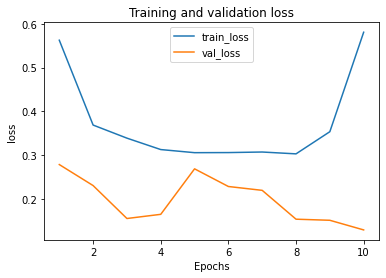

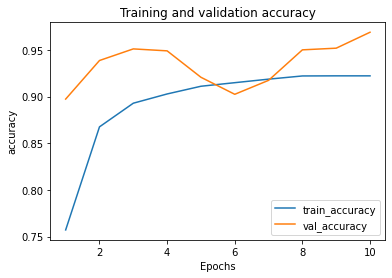

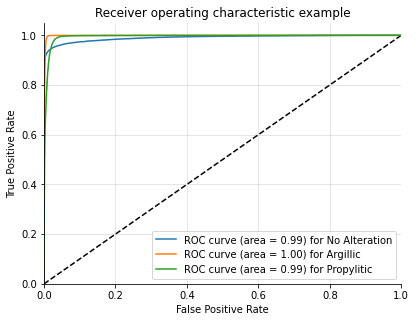

ROC AUC score: 0.994697125976744



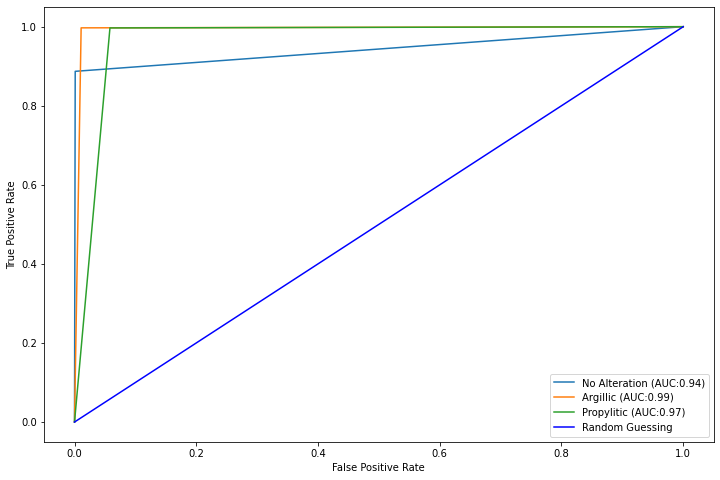

ROC AUC score: 0.9684605724080407

   Accuracy  precision    recall  F1_score     AUC_0     AUC_1     AUC_2  \
0  0.926914   0.941546  0.925216  0.927946  0.894214  0.986257  0.941034   
1  0.913632   0.925989  0.924660  0.921162  0.929277  0.966689  0.925175   
2  0.913373   0.914680  0.932900  0.920769  0.923918  0.987626  0.922910   
3  0.868463   0.852354  0.890415  0.855842  0.898076  0.938117  0.911157   
4  0.910695   0.935093  0.909572  0.914335  0.870513  0.988539  0.922582   
5  0.968936   0.969179  0.969330  0.968887  0.959618  0.991270  0.976836   
6  0.579204   0.810783  0.507818  0.444383  0.682620  0.514173  0.748499   
7  0.849498   0.905861  0.848259  0.851221  0.778289  0.987667  0.864896   
8  0.912931   0.937912  0.909598  0.916390  0.875295  0.983418  0.924587   
9  0.960235   0.964051  0.960339  0.960690  0.942967  0.993096  0.969319   

   Aggregate_AUC  
0       0.940502  
1       0.940380  
2       0.944818  
3       0.915783  
4       0.927211  
5       0.9759

In [ ]:
Model_name = 'CNN_RMSPROP'
NAME = 'ASTER_DATA'
optimiser_type = 'rmsprop'
experimental_runs = 10

best_model, best_history, df, avg_y_pred = CNN_model(Model_name, NAME, optimiser_type, experimental_runs)
best_model.save('Best_model_{}_{}'.format(NAME, Model_name))

train_x, train_y, test_x, test_y = get_data(NAME)
label_names = labels_for_datasets(NAME)

plot_metric(best_history, "loss")
print("")
plot_metric(best_history, "accuracy")
# plot_AUC_ROC(best_model, test_x, test_y, 3, label_names)
# print("")
plot_avg_AUC_ROC(avg_y_pred, test_y, 3, label_names)
print("")
avg_y_pred = avg_y_pred.argmax(axis=-1)
print('ROC AUC score:', multiclass_roc_auc_score(test_y, avg_y_pred, label_names))
#plot_ROC_curve(best_model, train_x, train_y, test_x, test_y)

print("")
print(df)
print(df.mean(axis = 0))

Epoch 1/10
11034/11034 [==============================] - 64s 5ms/step - loss: 0.3259 - accuracy: 0.8655 - val_loss: 0.1643 - val_accuracy: 0.9350
Epoch 2/10
11034/11034 [==============================] - 51s 5ms/step - loss: 0.1898 - accuracy: 0.9312 - val_loss: 0.1535 - val_accuracy: 0.9427
Epoch 3/10
11034/11034 [==============================] - 51s 5ms/step - loss: 0.1665 - accuracy: 0.9407 - val_loss: 0.1643 - val_accuracy: 0.9333
Epoch 4/10
11034/11034 [==============================] - 51s 5ms/step - loss: 0.1576 - accuracy: 0.9453 - val_loss: 0.1105 - val_accuracy: 0.9592
Epoch 5/10
11034/11034 [==============================] - 50s 5ms/step - loss: 0.1451 - accuracy: 0.9501 - val_loss: 0.1002 - val_accuracy: 0.9630
Epoch 6/10
11034/11034 [==============================] - 50s 5ms/step - loss: 0.1397 - accuracy: 0.9528 - val_loss: 0.1199 - val_accuracy: 0.9574
Epoch 7/10
11034/11034 [==============================] - 51s 5ms/step - loss: 0.1275 - accuracy: 0.9568 - val_loss: 0

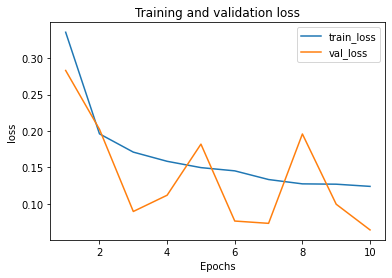

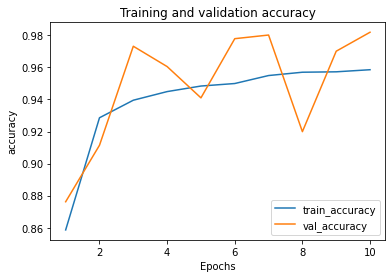

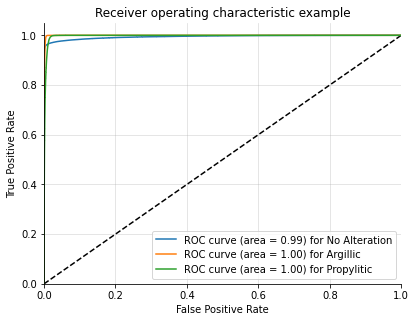

ROC AUC score: 0.9971652218858452



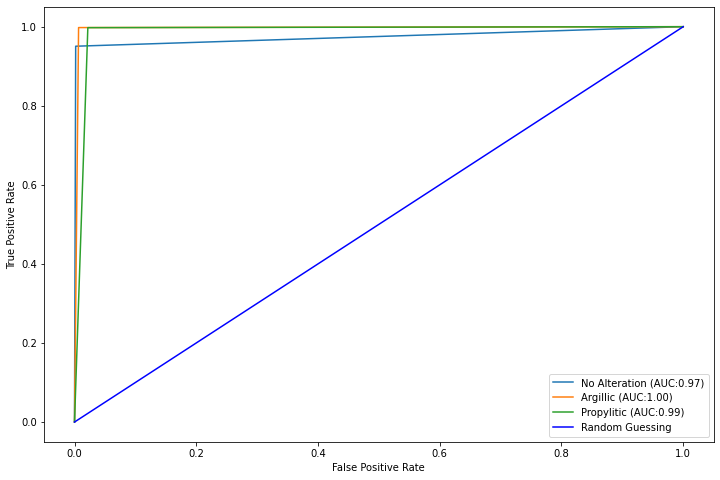

ROC AUC score: 0.9858965517585506

   Accuracy  precision    recall  F1_score     AUC_0     AUC_1     AUC_2  \
0  0.955999   0.954531  0.956179  0.953053  0.935310  0.989813  0.972395   
1  0.957626   0.964438  0.943355  0.952971  0.950797  0.951630  0.975518   
2  0.931120   0.948676  0.930345  0.934490  0.898247  0.992623  0.940784   
3  0.947689   0.960299  0.946635  0.950640  0.923078  0.993176  0.955151   
4  0.979858   0.980230  0.979865  0.979782  0.972061  0.995129  0.985309   
5  0.974148   0.976252  0.973951  0.974430  0.962060  0.995449  0.980544   
6  0.981855   0.979995  0.982589  0.981094  0.975721  0.995504  0.987901   
7  0.968965   0.973405  0.959338  0.965950  0.963410  0.966688  0.981838   
8  0.962087   0.967739  0.949469  0.957907  0.955939  0.956615  0.978753   
9  0.981957   0.981365  0.981960  0.981391  0.974332  0.995531  0.987827   

   Aggregate_AUC  
0       0.965839  
1       0.959315  
2       0.943884  
3       0.957135  
4       0.984166  
5       0.9793

In [ ]:
Model_name = 'CNN_ADAM'
NAME = 'ASTER_DATA'
optimiser_type = 'Adam'
experimental_runs = 10

best_model, best_history, df, avg_y_pred = CNN_model(Model_name, NAME, optimiser_type, experimental_runs)
best_model.save('Best_model_{}_{}'.format(NAME, Model_name))

train_x, train_y, test_x, test_y = get_data(NAME)
label_names = labels_for_datasets(NAME)

plot_metric(best_history, "loss")
print("")
plot_metric(best_history, "accuracy")
# plot_AUC_ROC(best_model, test_x, test_y, 3, label_names)
# print("")
plot_avg_AUC_ROC(avg_y_pred, test_y, 3, label_names)
print("")
avg_y_pred = avg_y_pred.argmax(axis=-1)
print('ROC AUC score:', multiclass_roc_auc_score(test_y, avg_y_pred, label_names))
#plot_ROC_curve(best_model, train_x, train_y, test_x, test_y)

print("")
print(df)
print(df.mean(axis = 0))

Epoch 1/10
11034/11034 [==============================] - 50s 5ms/step - loss: 0.6401 - accuracy: 0.6933 - val_loss: 0.4276 - val_accuracy: 0.8298
Epoch 2/10
11034/11034 [==============================] - 50s 5ms/step - loss: 0.3660 - accuracy: 0.8491 - val_loss: 1.0279 - val_accuracy: 0.6101
Epoch 3/10
11034/11034 [==============================] - 50s 4ms/step - loss: 0.2487 - accuracy: 0.9084 - val_loss: 0.2077 - val_accuracy: 0.9150
Epoch 4/10
11034/11034 [==============================] - 49s 4ms/step - loss: 0.1977 - accuracy: 0.9294 - val_loss: 0.1348 - val_accuracy: 0.9510
Epoch 5/10
11034/11034 [==============================] - 50s 5ms/step - loss: 0.1716 - accuracy: 0.9395 - val_loss: 0.1248 - val_accuracy: 0.9610
Epoch 6/10
11034/11034 [==============================] - 50s 4ms/step - loss: 0.1569 - accuracy: 0.9454 - val_loss: 0.1445 - val_accuracy: 0.9430
Epoch 7/10
11034/11034 [==============================] - 50s 5ms/step - loss: 0.1466 - accuracy: 0.9498 - val_loss: 0

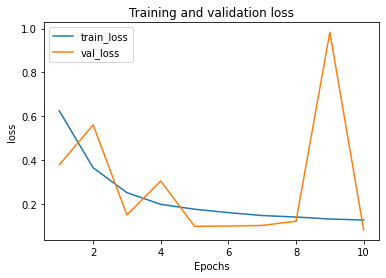

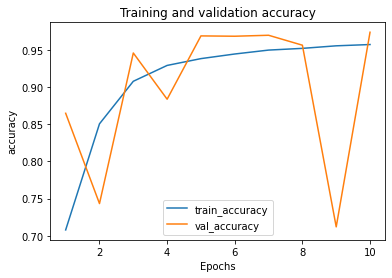

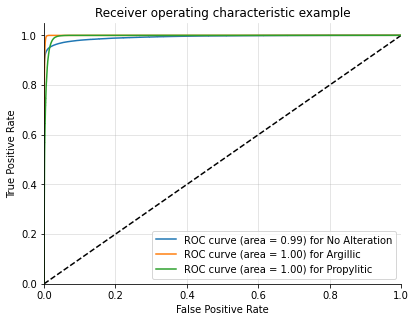

ROC AUC score: 0.9961751202638528



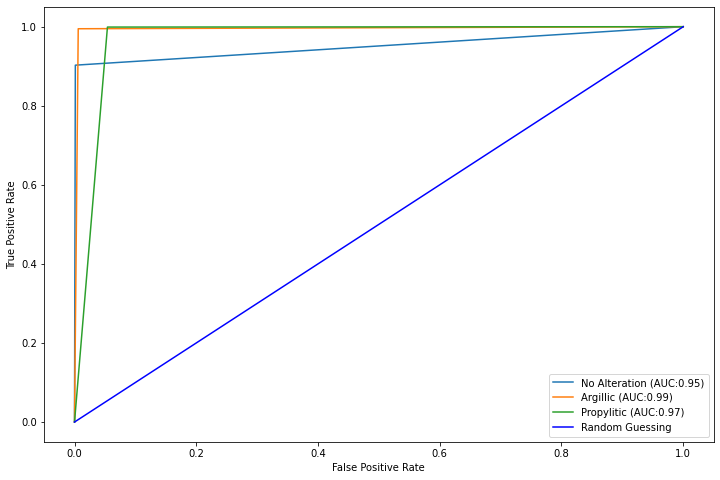

ROC AUC score: 0.9724837108500939

   Accuracy  precision    recall  F1_score     AUC_0     AUC_1     AUC_2  \
0  0.965677   0.972137  0.960917  0.965887  0.953812  0.982298  0.974136   
1  0.968307   0.973488  0.967346  0.969559  0.954324  0.993526  0.974390   
2  0.970779   0.966631  0.972840  0.969229  0.962941  0.992875  0.980251   
3  0.963761   0.971517  0.961823  0.965564  0.948062  0.991325  0.969920   
4  0.973511   0.973708  0.973813  0.973184  0.962522  0.994551  0.980966   
5  0.932310   0.950594  0.922020  0.933466  0.909688  0.964930  0.945613   
6  0.969628   0.974590  0.966724  0.970181  0.958975  0.987234  0.976527   
7  0.874103   0.924978  0.870402  0.880617  0.816557  0.986092  0.882513   
8  0.963697   0.962067  0.970240  0.965940  0.963832  0.994570  0.968858   
9  0.966183   0.971919  0.965490  0.967640  0.950649  0.994340  0.972462   

   Aggregate_AUC  
0       0.970082  
1       0.974080  
2       0.978689  
3       0.969769  
4       0.979346  
5       0.9400

In [ ]:
Model_name = 'CNN_SGD'
NAME = 'ASTER_DATA'
optimiser_type = 'SGD'
experimental_runs = 10

best_model, best_history, df, avg_y_pred = CNN_model(Model_name, NAME, optimiser_type, experimental_runs)
best_model.save('Best_model_{}_{}'.format(NAME, Model_name))

train_x, train_y, test_x, test_y = get_data(NAME)
label_names = labels_for_datasets(NAME)

plot_metric(best_history, "loss")
print("")
plot_metric(best_history, "accuracy")
# plot_AUC_ROC(best_model, test_x, test_y, 3, label_names)
# print("")
plot_avg_AUC_ROC(avg_y_pred, test_y, 3, label_names)
print("")
avg_y_pred = avg_y_pred.argmax(axis=-1)
print('ROC AUC score:', multiclass_roc_auc_score(test_y, avg_y_pred, label_names))
#plot_ROC_curve(best_model, train_x, train_y, test_x, test_y)

print("")
print(df)
print(df.mean(axis = 0))

##LANDSAT8 Dataset - CNN Models


Epoch 1/10
1815/1815 [==============================] - 11s 6ms/step - loss: 0.7806 - accuracy: 0.6561 - val_loss: 1.3800 - val_accuracy: 0.4642
Epoch 2/10
1815/1815 [==============================] - 18s 10ms/step - loss: 0.5814 - accuracy: 0.7678 - val_loss: 0.3703 - val_accuracy: 0.8706
Epoch 3/10
1815/1815 [==============================] - 12s 7ms/step - loss: 0.4802 - accuracy: 0.8161 - val_loss: 0.2925 - val_accuracy: 0.8967
Epoch 4/10
1815/1815 [==============================] - 12s 7ms/step - loss: 0.4255 - accuracy: 0.8376 - val_loss: 0.2621 - val_accuracy: 0.9068
Epoch 5/10
1815/1815 [==============================] - 13s 7ms/step - loss: 0.3945 - accuracy: 0.8516 - val_loss: 0.4122 - val_accuracy: 0.8194
Epoch 6/10
1815/1815 [==============================] - 10s 6ms/step - loss: 0.3814 - accuracy: 0.8595 - val_loss: 0.3369 - val_accuracy: 0.8720
Epoch 7/10
1815/1815 [==============================] - 10s 5ms/step - loss: 0.3650 - accuracy: 0.8663 - val_loss: 0.2807 - val_a

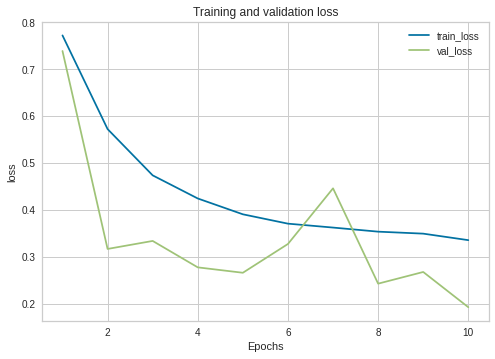

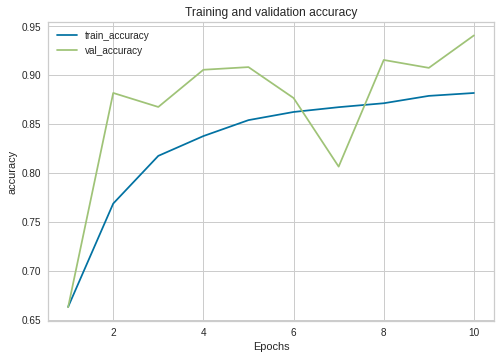

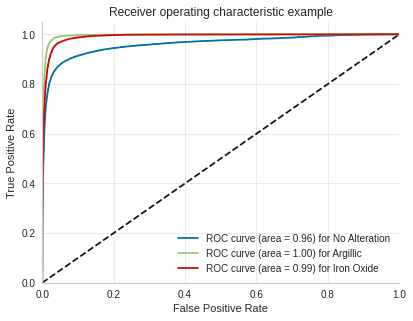

ROC AUC score: 0.9820624250363693



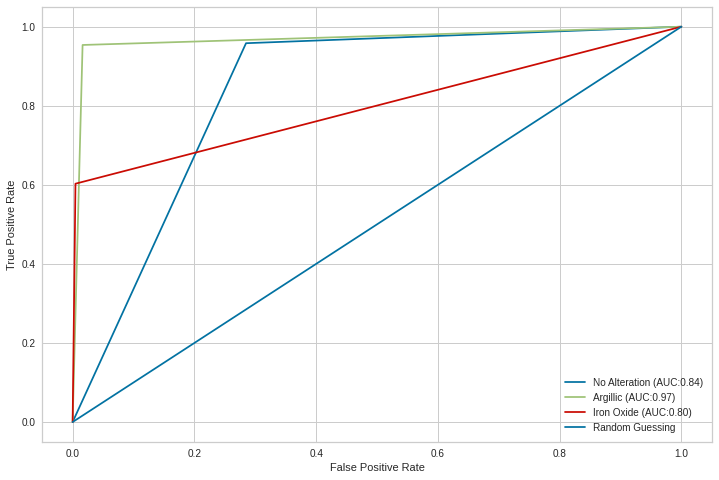

ROC AUC score: 0.868160200498081

   Accuracy  precision    recall  F1_score     AUC_0     AUC_1     AUC_2  \
0  0.938481   0.934434  0.938753  0.935754  0.923626  0.973188  0.963321   
1  0.912190   0.924328  0.901033  0.910154  0.891252  0.943630  0.941838   
2  0.925723   0.930906  0.916941  0.922175  0.931746  0.930849  0.954913   
3  0.903461   0.889697  0.915294  0.898539  0.899747  0.964984  0.939734   
4  0.881637   0.903851  0.878931  0.883190  0.903503  0.910579  0.914121   
5  0.853693   0.895310  0.843453  0.853614  0.806368  0.946098  0.883079   
6  0.842020   0.889156  0.838326  0.838647  0.777864  0.965860  0.874944   
7  0.840832   0.832781  0.866262  0.839843  0.843835  0.952904  0.890376   
8  0.940522   0.941094  0.935403  0.938100  0.933143  0.958787  0.963438   
9  0.795635   0.853511  0.838265  0.818881  0.836684  0.968704  0.799092   

   Aggregate_AUC  
0       0.953378  
1       0.925574  
2       0.939169  
3       0.934822  
4       0.909401  
5       0.87851

In [ ]:
Model_name = 'CNN_RMSPROP'
NAME = 'LANDSAT8_DATA'
optimiser_type = 'rmsprop'
experimental_runs = 10

best_model, best_history, df, avg_y_pred = CNN_model(Model_name, NAME, optimiser_type, experimental_runs)
best_model.save('Best_model_{}_{}'.format(NAME, Model_name))

train_x, train_y, test_x, test_y = get_data(NAME)
label_names = labels_for_datasets(NAME)

plot_metric(best_history, "loss")
print("")
plot_metric(best_history, "accuracy")
# plot_AUC_ROC(best_model, test_x, test_y, 3, label_names)
# print("")
plot_avg_AUC_ROC(avg_y_pred, test_y, 3, label_names)
print("")
avg_y_pred = avg_y_pred.argmax(axis=-1)
print('ROC AUC score:', multiclass_roc_auc_score(test_y, avg_y_pred, label_names))
#plot_ROC_curve(best_model, train_x, train_y, test_x, test_y)

print("")
print(df)
print(df.mean(axis = 0))

Epoch 1/10
1815/1815 [==============================] - 16s 8ms/step - loss: 0.5284 - accuracy: 0.7725 - val_loss: 0.3566 - val_accuracy: 0.8610
Epoch 2/10
1815/1815 [==============================] - 9s 5ms/step - loss: 0.3555 - accuracy: 0.8594 - val_loss: 0.2656 - val_accuracy: 0.9037
Epoch 3/10
1815/1815 [==============================] - 9s 5ms/step - loss: 0.3033 - accuracy: 0.8822 - val_loss: 0.3200 - val_accuracy: 0.8619
Epoch 4/10
1815/1815 [==============================] - 9s 5ms/step - loss: 0.2789 - accuracy: 0.8967 - val_loss: 0.1632 - val_accuracy: 0.9405
Epoch 5/10
1815/1815 [==============================] - 9s 5ms/step - loss: 0.2522 - accuracy: 0.9064 - val_loss: 0.1921 - val_accuracy: 0.9291
Epoch 6/10
1815/1815 [==============================] - 9s 5ms/step - loss: 0.2386 - accuracy: 0.9121 - val_loss: 0.2097 - val_accuracy: 0.9168
Epoch 7/10
1815/1815 [==============================] - 9s 5ms/step - loss: 0.2228 - accuracy: 0.9193 - val_loss: 0.1333 - val_accuracy

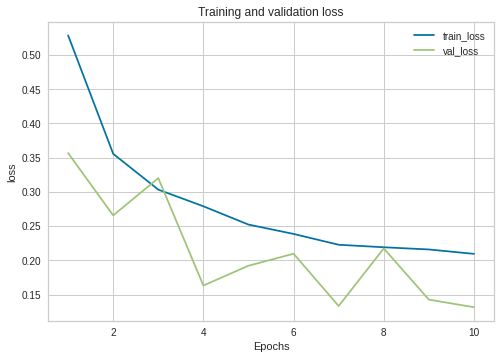

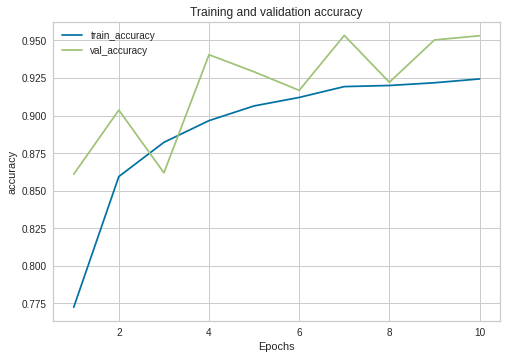

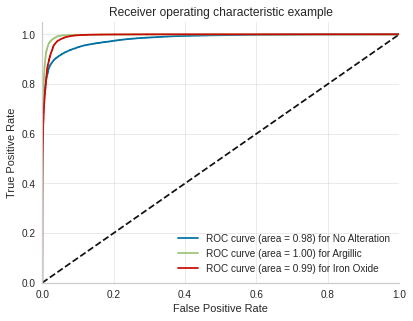

ROC AUC score: 0.9902587275613174



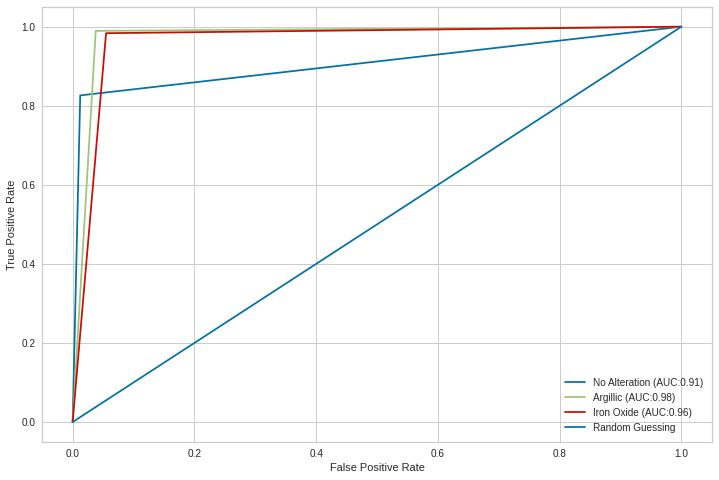

ROC AUC score: 0.9489532189236677

    Accuracy  precision    recall  F1_score     AUC_0     AUC_1     AUC_2  \
0   0.921668   0.913173  0.922561  0.911026  0.890753  0.964396  0.971525   
1   0.932645   0.938993  0.914548  0.924212  0.937227  0.912458  0.968369   
2   0.948295   0.952170  0.936750  0.943723  0.944892  0.944707  0.973301   
3   0.927634   0.919206  0.936028  0.926443  0.924244  0.976100  0.950843   
4   0.933678   0.932584  0.940549  0.935530  0.938148  0.975024  0.947930   
5   0.921023   0.928293  0.907726  0.915006  0.930544  0.913907  0.955624   
6   0.951265   0.951445  0.944404  0.947754  0.947766  0.956512  0.973720   
7   0.925465   0.915959  0.927743  0.916067  0.899053  0.967809  0.970729   
8   0.932929   0.942171  0.925526  0.931810  0.914514  0.961600  0.954839   
9   0.941942   0.935257  0.942502  0.936813  0.922952  0.974968  0.971869   
10  0.953125   0.949046  0.952962  0.950596  0.942635  0.977332  0.973275   
11  0.923321   0.932998  0.897166  0.9105

In [ ]:
Model_name = 'CNN_ADAM'
NAME = 'LANDSAT8_DATA'
optimiser_type = 'Adam'
experimental_runs = 10

best_model, best_history, df, avg_y_pred = CNN_model(Model_name, NAME, optimiser_type, experimental_runs)
best_model.save('Best_model_{}_{}'.format(NAME, Model_name))

train_x, train_y, test_x, test_y = get_data(NAME)
label_names = labels_for_datasets(NAME)

plot_metric(best_history, "loss")
print("")
plot_metric(best_history, "accuracy")

plot_avg_AUC_ROC(avg_y_pred, test_y, 3, label_names)
print("")
avg_y_pred = avg_y_pred.argmax(axis=-1)
print('ROC AUC score:', multiclass_roc_auc_score(test_y, avg_y_pred, label_names))

print("")
print(df)
print(df.mean(axis = 0))

Epoch 1/10
1815/1815 [==============================] - 18s 10ms/step - loss: 1.0133 - accuracy: 0.4933 - val_loss: 0.8815 - val_accuracy: 0.6098
Epoch 2/10
1815/1815 [==============================] - 25s 14ms/step - loss: 0.8297 - accuracy: 0.6256 - val_loss: 0.6616 - val_accuracy: 0.6996
Epoch 3/10
1815/1815 [==============================] - 14s 8ms/step - loss: 0.6472 - accuracy: 0.7272 - val_loss: 0.4116 - val_accuracy: 0.8484
Epoch 4/10
1815/1815 [==============================] - 16s 9ms/step - loss: 0.5381 - accuracy: 0.7821 - val_loss: 0.3630 - val_accuracy: 0.8593
Epoch 5/10
1815/1815 [==============================] - 25s 14ms/step - loss: 0.4722 - accuracy: 0.8138 - val_loss: 0.3786 - val_accuracy: 0.8529
Epoch 6/10
1815/1815 [==============================] - 18s 10ms/step - loss: 0.4260 - accuracy: 0.8357 - val_loss: 0.3891 - val_accuracy: 0.8433
Epoch 7/10
1815/1815 [==============================] - 19s 11ms/step - loss: 0.3876 - accuracy: 0.8502 - val_loss: 0.2908 - v

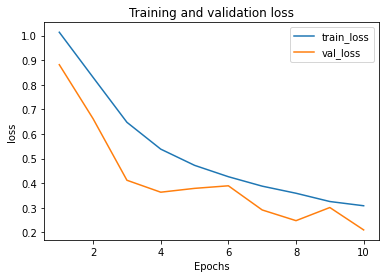

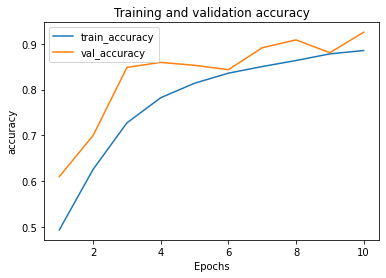

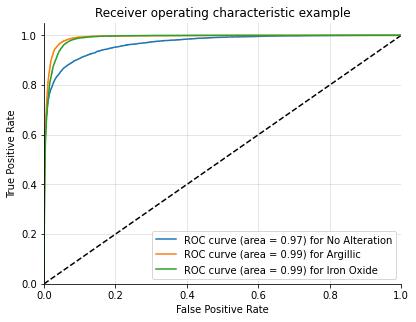

ROC AUC score: 0.9826793171951782



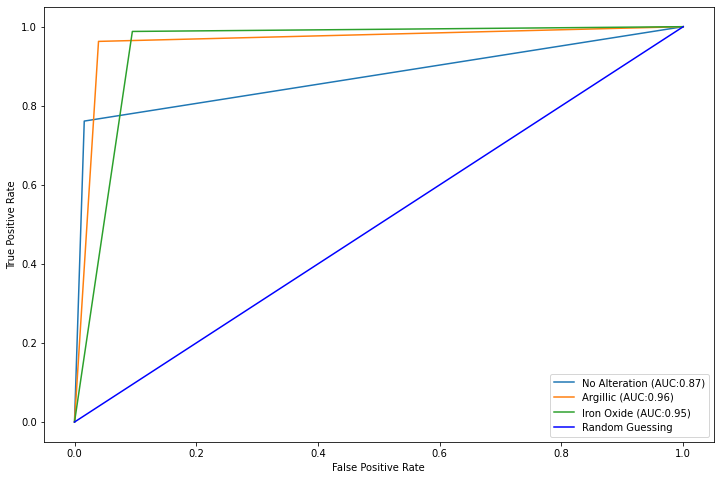

ROC AUC score: 0.9269226188026732

   Accuracy  precision    recall  F1_score     AUC_0     AUC_1     AUC_2  \
0  0.925155   0.925120  0.918239  0.921108  0.910478  0.949922  0.956656   
1  0.923631   0.924080  0.916544  0.919862  0.910293  0.948095  0.954873   
2  0.814101   0.866824  0.802544  0.809158  0.748836  0.937471  0.853029   
3  0.920532   0.915427  0.919100  0.915985  0.900503  0.960930  0.955174   
4  0.920584   0.920119  0.916657  0.917923  0.920117  0.942965  0.950681   
5  0.907076   0.898924  0.910606  0.903753  0.890339  0.961629  0.943152   
6  0.909039   0.915767  0.904474  0.905837  0.878740  0.960920  0.941417   
7  0.898502   0.909318  0.870832  0.883993  0.903145  0.867296  0.955130   
8  0.916529   0.920309  0.904766  0.911761  0.909853  0.928565  0.951363   
9  0.906353   0.907386  0.904005  0.900257  0.872622  0.961682  0.946464   

   Aggregate_AUC  
0       0.939019  
1       0.937753  
2       0.846445  
3       0.938869  
4       0.937921  
5       0.9317

In [ ]:
Model_name = 'CNN_SGD'
NAME = 'LANDSAT8_DATA'
optimiser_type = 'SGD'
experimental_runs = 10

best_model, best_history, df, avg_y_pred = CNN_model(Model_name, NAME, optimiser_type, experimental_runs)
best_model.save('Best_model_{}_{}'.format(NAME, Model_name))

train_x, train_y, test_x, test_y = get_data(NAME)
label_names = labels_for_datasets(NAME)

plot_metric(best_history, "loss")
print("")
plot_metric(best_history, "accuracy")

plot_avg_AUC_ROC(avg_y_pred, test_y, 3, label_names)
print("")
avg_y_pred = avg_y_pred.argmax(axis=-1)
print('ROC AUC score:', multiclass_roc_auc_score(test_y, avg_y_pred, label_names))

print("")
print(df)
print(df.mean(axis = 0))

##MLP Model

In [ ]:
############## ORiginal Model Code ###################
def MLP_model(Model_name, NAME, optimiser_type, experimental_runs):
  best_accuracy = 0
  best_model = Sequential()
  best_history = None
  train_x, train_y, test_x, test_y = get_data(NAME)
  reshaped_train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1]*train_x.shape[2]*train_x.shape[3]))
  reshaped_test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1]*test_x.shape[2]*test_x.shape[3]))

  for i in range(experimental_runs):
    #Model_name = "CNN_RMSPROP"

    model = Sequential()

    model.add(Dense(64, activation='relu', input_shape=(train_x.shape[1]* train_x.shape[2]* train_x.shape[3],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))


    #print(model.summary())
    #tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

    log_folder = "logs/{}".format(NAME)

    callbacks = [TensorBoard(log_dir=log_folder,
                    histogram_freq=1,
                      write_graph=True,
                      write_images=True,
                      update_freq='epoch',
                      profile_batch=2,
                      embeddings_freq=1)]

    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimiser_type, metrics=['accuracy'])
    history = model.fit(reshaped_train_x, train_y, epochs = 10, validation_data = (reshaped_test_x, test_y))


    n_classes = 3

    #This function calculates all the evaluation metrics for every iteration
    Accuracy, precision, recall, F1_score, roc_auc = compileResults(model, reshaped_test_x, test_y, n_classes)
    result_array = [Accuracy, precision, recall, F1_score]
    sum_of_roc_scores = 0
    for i in range(n_classes):
      result_array.append(roc_auc[i])
      sum_of_roc_scores = sum_of_roc_scores + roc_auc[i]

    aggreagate_roc_score = sum_of_roc_scores/n_classes
    result_array.append(aggreagate_roc_score)
    
    result_dict["{}_{}".format(NAME, Model_name)].append(result_array)

    if best_accuracy < Accuracy:
      best_model = model
      best_accuracy = Accuracy
      best_history = history
    sum_y_pred = 0
    y_pred = model.predict(reshaped_test_x, batch_size=64, verbose=1)
    sum_y_pred = sum_y_pred + y_pred

  #results_df = results_df.append({'Model' : '{}_{}_MODEL'.format(NAME, Model_name), 'Accuracy' : Accuracy, 'F1-Score': F1_score, 'Precision': precision, 'Recall': recall }, ignore_index = True)

  columns = ['Accuracy', 'precision', 'recall', 'F1_score', 'AUC_0', 'AUC_1', 'AUC_2', "Aggregate_AUC"]
  result_array = np.array(result_dict["{}_{}".format(NAME, Model_name)])
  result_array = np.transpose(result_array)
  df = pd.DataFrame(result_array, columns)
  #df.set_index('Attribute',inplace=True)
  df = df.transpose()
  df.to_csv("{}_{}.csv".format(NAME, Model_name))

  return best_model, best_history, df, sum_y_pred/experimental_runs

##MLP - Landsat8 Data

Epoch 1/10
1815/1815 [==============================] - 11s 5ms/step - loss: 0.8053 - accuracy: 0.6296 - val_loss: 0.5020 - val_accuracy: 0.8132
Epoch 2/10
1815/1815 [==============================] - 7s 4ms/step - loss: 0.6089 - accuracy: 0.7426 - val_loss: 0.4981 - val_accuracy: 0.7901
Epoch 3/10
1815/1815 [==============================] - 6s 3ms/step - loss: 0.5309 - accuracy: 0.7764 - val_loss: 0.3968 - val_accuracy: 0.8367
Epoch 4/10
1815/1815 [==============================] - 7s 4ms/step - loss: 0.4907 - accuracy: 0.7955 - val_loss: 0.4452 - val_accuracy: 0.8307
Epoch 5/10
1815/1815 [==============================] - 7s 4ms/step - loss: 0.4625 - accuracy: 0.8086 - val_loss: 0.4082 - val_accuracy: 0.8280
Epoch 6/10
1815/1815 [==============================] - 7s 4ms/step - loss: 0.4417 - accuracy: 0.8196 - val_loss: 0.4858 - val_accuracy: 0.8114
Epoch 7/10
1815/1815 [==============================] - 7s 4ms/step - loss: 0.4256 - accuracy: 0.8249 - val_loss: 0.3443 - val_accuracy

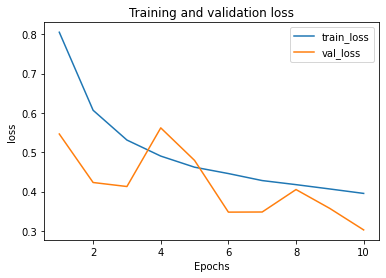

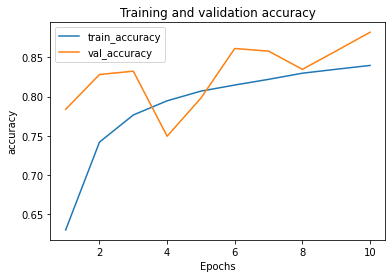

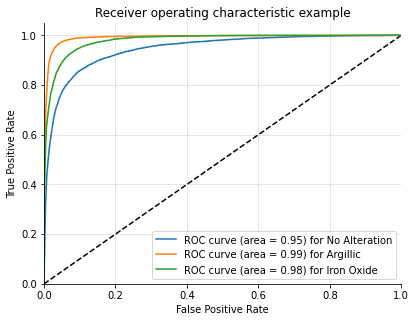

ROC AUC score: 0.9720207636937496



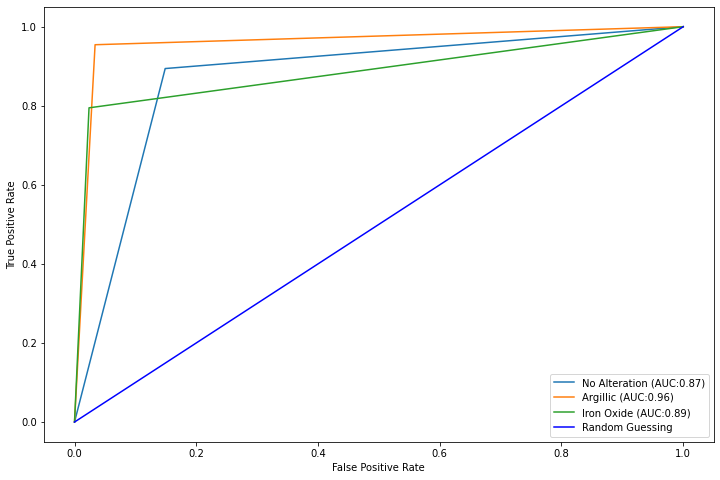

ROC AUC score: 0.9061068526823742

    Accuracy  precision    recall  F1_score     AUC_0     AUC_1     AUC_2  \
0   0.840522   0.872537  0.845751  0.847949  0.866112  0.906269  0.874567   
1   0.879985   0.883095  0.881655  0.881176  0.857532  0.956740  0.910499   
2   0.716296   0.788341  0.641409  0.657311  0.727239  0.674921  0.817228   
3   0.801937   0.816395  0.838634  0.812521  0.822688  0.958158  0.832452   
4   0.873089   0.864997  0.881172  0.870513  0.849830  0.959350  0.914748   
5   0.846384   0.851568  0.866991  0.854907  0.851055  0.959736  0.873678   
6   0.881921   0.877995  0.889451  0.883210  0.869031  0.959694  0.913672   
7   0.868569   0.867950  0.878746  0.872795  0.859879  0.957654  0.898313   
8   0.859478   0.860199  0.870800  0.864940  0.850755  0.956773  0.888825   
9   0.866374   0.866583  0.881489  0.871823  0.866014  0.960552  0.894187   
10  0.861467   0.866566  0.881077  0.868568  0.872577  0.960288  0.885456   

    Aggregate_AUC  
0        0.882316  


In [ ]:
Model_name = 'MLP_RMSPROP'
NAME = 'LANDSAT8_DATA'
optimiser_type = 'rmsprop'
experimental_runs = 10

best_model, best_history, df, avg_y_pred = MLP_model(Model_name, NAME, optimiser_type, experimental_runs)
best_model.save('Best_model_{}_{}'.format(NAME, Model_name))

train_x, train_y, test_x, test_y = get_data(NAME)
label_names = labels_for_datasets(NAME)

plot_metric(best_history, "loss")
print("")
plot_metric(best_history, "accuracy")
# plot_AUC_ROC(best_model, test_x, test_y, 3, label_names)
# print("")
plot_avg_AUC_ROC(avg_y_pred, test_y, 3, label_names)
print("")
avg_y_pred = avg_y_pred.argmax(axis=-1)
print('ROC AUC score:', multiclass_roc_auc_score(test_y, avg_y_pred, label_names))
#plot_ROC_curve(best_model, train_x, train_y, test_x, test_y)

print("")
print(df)
print(df.mean(axis = 0))

Epoch 1/10
1815/1815 [==============================] - 10s 5ms/step - loss: 0.5859 - accuracy: 0.7422 - val_loss: 0.4604 - val_accuracy: 0.8033
Epoch 2/10
1815/1815 [==============================] - 7s 4ms/step - loss: 0.4313 - accuracy: 0.8176 - val_loss: 0.4107 - val_accuracy: 0.8359
Epoch 3/10
1815/1815 [==============================] - 6s 3ms/step - loss: 0.3946 - accuracy: 0.8366 - val_loss: 0.3713 - val_accuracy: 0.8503
Epoch 4/10
1815/1815 [==============================] - 8s 4ms/step - loss: 0.3690 - accuracy: 0.8485 - val_loss: 0.2986 - val_accuracy: 0.8862
Epoch 5/10
1815/1815 [==============================] - 10s 5ms/step - loss: 0.3476 - accuracy: 0.8596 - val_loss: 0.3635 - val_accuracy: 0.8549
Epoch 6/10
1815/1815 [==============================] - 6s 4ms/step - loss: 0.3272 - accuracy: 0.8694 - val_loss: 0.2658 - val_accuracy: 0.8976
Epoch 7/10
1815/1815 [==============================] - 11s 6ms/step - loss: 0.3126 - accuracy: 0.8752 - val_loss: 0.2465 - val_accura

INFO:tensorflow:Assets written to: Best_model_LANDSAT8_DATA_MLP_ADAM/assets


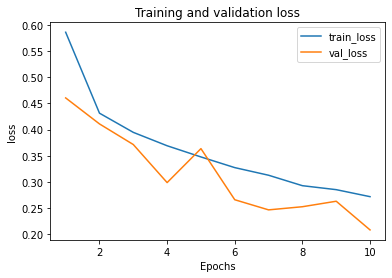

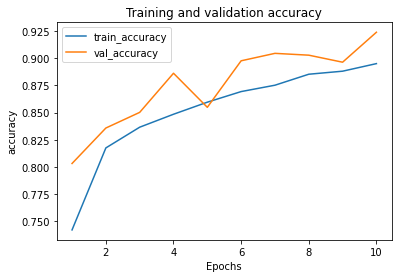

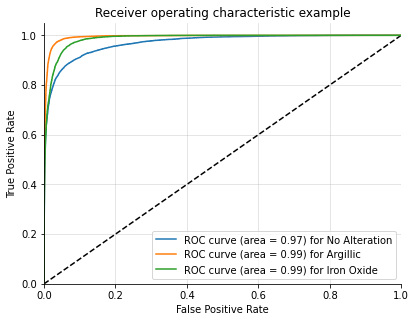

ROC AUC score: 0.9833144171540394



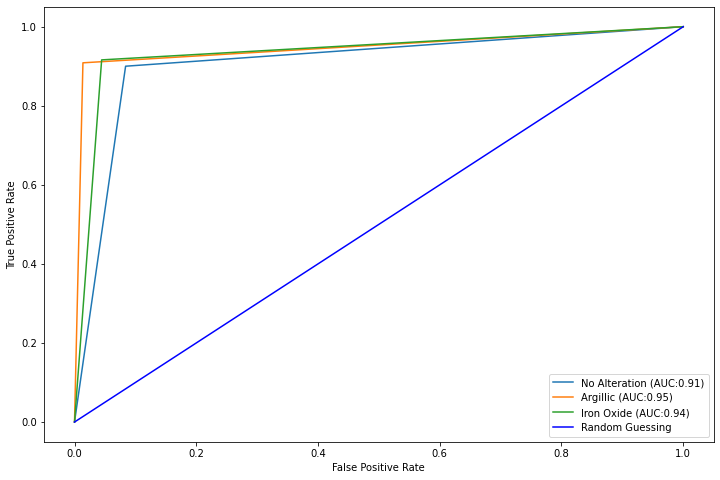

ROC AUC score: 0.9303874661557522

   Accuracy  precision    recall  F1_score     AUC_0     AUC_1     AUC_2  \
0  0.923889   0.920624  0.925572  0.922995  0.916263  0.964848  0.948119   
1  0.892278   0.909856  0.885247  0.891336  0.857709  0.955270  0.922300   
2  0.849044   0.881510  0.841367  0.849270  0.874317  0.877502  0.894301   
3  0.919060   0.915063  0.920876  0.917568  0.907263  0.965139  0.945724   
4  0.907696   0.908740  0.914234  0.910027  0.912182  0.959379  0.929829   
5  0.886209   0.903233  0.872663  0.884159  0.864254  0.927694  0.919764   
6  0.903538   0.894190  0.909315  0.898685  0.882693  0.966199  0.942263   
7  0.907515   0.903590  0.910669  0.905712  0.888226  0.967094  0.937958   
8  0.920997   0.923031  0.915404  0.918964  0.910440  0.949831  0.949034   
9  0.909091   0.911696  0.908221  0.909473  0.908048  0.947393  0.935721   

   Aggregate_AUC  
0       0.943077  
1       0.911760  
2       0.882040  
3       0.939375  
4       0.933797  
5       0.9039

In [ ]:
Model_name = 'MLP_ADAM'
NAME = 'LANDSAT8_DATA'
optimiser_type = 'Adam'
experimental_runs = 10

best_model, best_history, df, avg_y_pred = MLP_model(Model_name, NAME, optimiser_type, experimental_runs)
best_model.save('Best_model_{}_{}'.format(NAME, Model_name))

train_x, train_y, test_x, test_y = get_data(NAME)
label_names = labels_for_datasets(NAME)

plot_metric(best_history, "loss")
print("")
plot_metric(best_history, "accuracy")

plot_avg_AUC_ROC(avg_y_pred, test_y, 3, label_names)
print("")
avg_y_pred = avg_y_pred.argmax(axis=-1)
print('ROC AUC score:', multiclass_roc_auc_score(test_y, avg_y_pred, label_names))

print("")
print(df)
print(df.mean(axis = 0))

Epoch 1/10
1815/1815 [==============================] - 5s 3ms/step - loss: 1.0101 - accuracy: 0.4772 - val_loss: 0.9505 - val_accuracy: 0.5186
Epoch 2/10
1815/1815 [==============================] - 6s 3ms/step - loss: 0.8278 - accuracy: 0.6199 - val_loss: 0.6714 - val_accuracy: 0.6869
Epoch 3/10
1815/1815 [==============================] - 5s 3ms/step - loss: 0.6534 - accuracy: 0.7209 - val_loss: 0.4764 - val_accuracy: 0.8037
Epoch 4/10
1815/1815 [==============================] - 6s 3ms/step - loss: 0.5432 - accuracy: 0.7727 - val_loss: 0.4283 - val_accuracy: 0.8198
Epoch 5/10
1815/1815 [==============================] - 6s 3ms/step - loss: 0.4841 - accuracy: 0.7991 - val_loss: 0.4087 - val_accuracy: 0.8332
Epoch 6/10
1815/1815 [==============================] - 5s 3ms/step - loss: 0.4502 - accuracy: 0.8141 - val_loss: 0.5060 - val_accuracy: 0.7871
Epoch 7/10
1815/1815 [==============================] - 6s 3ms/step - loss: 0.4186 - accuracy: 0.8268 - val_loss: 0.3485 - val_accuracy:

INFO:tensorflow:Assets written to: Best_model_LANDSAT8_DATA_MLP_SGD/assets


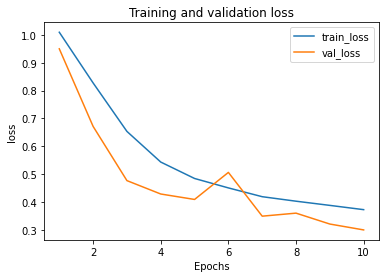

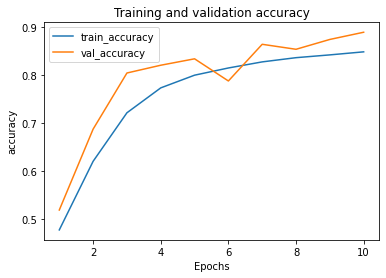

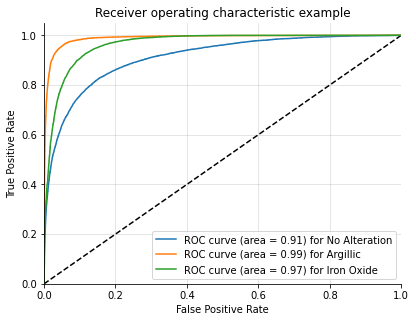

ROC AUC score: 0.9552051171442401



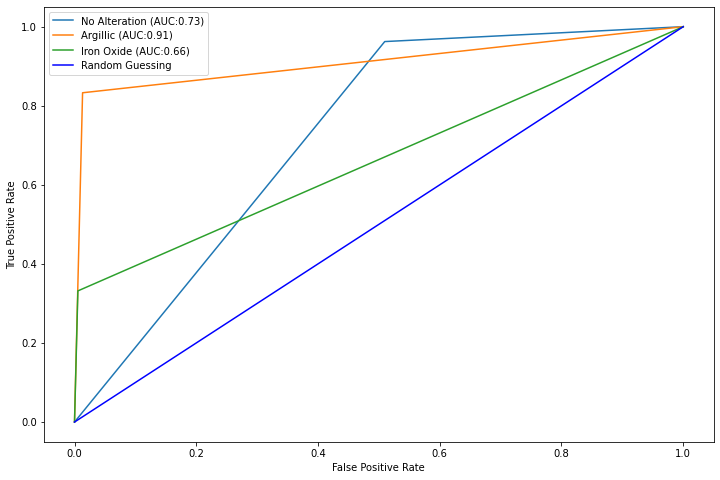

ROC AUC score: 0.7664154837509569

   Accuracy  precision    recall  F1_score     AUC_0     AUC_1     AUC_2  \
0  0.888456   0.890814  0.886663  0.888656  0.875857  0.943544  0.921153   
1  0.884504   0.887593  0.881446  0.884398  0.873232  0.937102  0.919346   
2  0.837913   0.834875  0.861099  0.841921  0.840969  0.955064  0.876518   
3  0.877402   0.882455  0.876011  0.878699  0.873559  0.931855  0.911612   
4  0.873011   0.878306  0.875680  0.875959  0.873361  0.935885  0.905089   
5  0.800232   0.849529  0.790121  0.793445  0.730841  0.936000  0.842873   
6  0.859427   0.877728  0.850605  0.858177  0.871944  0.889481  0.905210   
7  0.880010   0.886428  0.875173  0.879242  0.856088  0.942327  0.915353   
8  0.826420   0.830968  0.853750  0.833589  0.834645  0.955866  0.862826   
9  0.648528   0.804318  0.708973  0.676403  0.726358  0.909807  0.663081   

   Aggregate_AUC  
0       0.913518  
1       0.909893  
2       0.890851  
3       0.905676  
4       0.904779  
5       0.8365

In [ ]:
Model_name = 'MLP_SGD'
NAME = 'LANDSAT8_DATA'
optimiser_type = 'SGD'
experimental_runs = 10

best_model, best_history, df, avg_y_pred = MLP_model(Model_name, NAME, optimiser_type, experimental_runs)
best_model.save('Best_model_{}_{}'.format(NAME, Model_name))

train_x, train_y, test_x, test_y = get_data(NAME)
label_names = labels_for_datasets(NAME)

plot_metric(best_history, "loss")
print("")
plot_metric(best_history, "accuracy")

plot_avg_AUC_ROC(avg_y_pred, test_y, 3, label_names)
print("")
avg_y_pred = avg_y_pred.argmax(axis=-1)
print('ROC AUC score:', multiclass_roc_auc_score(test_y, avg_y_pred, label_names))

print("")
print(df)
print(df.mean(axis = 0))

##MLP - ASTER Data

Epoch 1/10
11034/11034 [==============================] - 43s 4ms/step - loss: 0.5670 - accuracy: 0.7391 - val_loss: 0.3640 - val_accuracy: 0.8484
Epoch 2/10
11034/11034 [==============================] - 40s 4ms/step - loss: 0.4239 - accuracy: 0.8183 - val_loss: 0.5137 - val_accuracy: 0.7580
Epoch 3/10
11034/11034 [==============================] - 39s 4ms/step - loss: 0.3817 - accuracy: 0.8419 - val_loss: 0.3982 - val_accuracy: 0.8211
Epoch 4/10
11034/11034 [==============================] - 39s 4ms/step - loss: 0.3618 - accuracy: 0.8543 - val_loss: 0.4625 - val_accuracy: 0.8082
Epoch 5/10
11034/11034 [==============================] - 39s 4ms/step - loss: 0.3448 - accuracy: 0.8638 - val_loss: 0.5242 - val_accuracy: 0.8234
Epoch 6/10
11034/11034 [==============================] - 39s 4ms/step - loss: 0.3372 - accuracy: 0.8699 - val_loss: 0.6676 - val_accuracy: 0.6560
Epoch 7/10
11034/11034 [==============================] - 39s 4ms/step - loss: 0.3229 - accuracy: 0.8752 - val_loss: 0

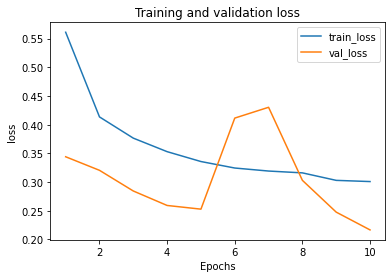

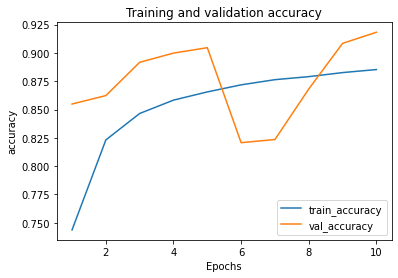

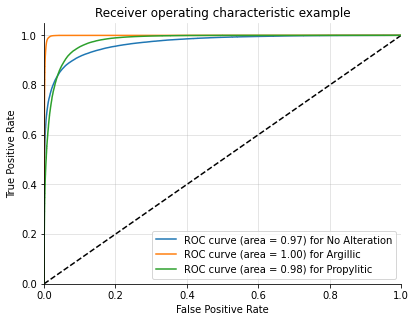

ROC AUC score: 0.9823134740015146



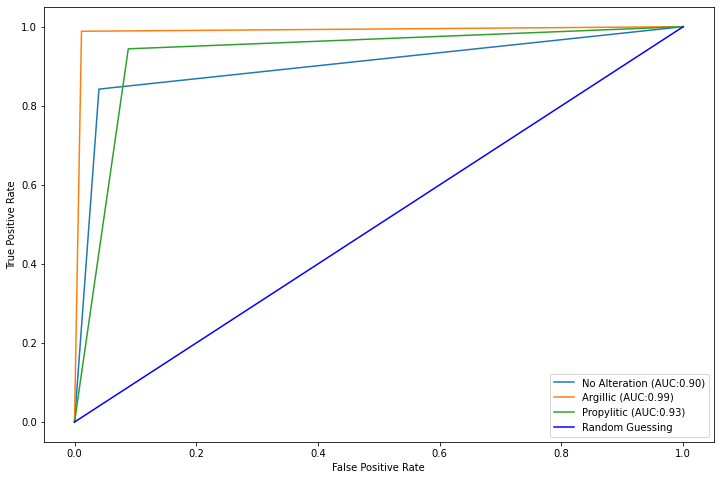

ROC AUC score: 0.9390967689172225

   Accuracy  precision    recall  F1_score     AUC_0     AUC_1     AUC_2  \
0  0.777766   0.873987  0.755632  0.770076  0.700250  0.925634  0.794980   
1  0.913880   0.922103  0.918934  0.918340  0.888961  0.988941  0.925449   
2  0.911816   0.916343  0.917658  0.914807  0.887633  0.987163  0.926271   
3  0.916251   0.918395  0.928448  0.923154  0.912641  0.987641  0.924540   
4  0.911646   0.920495  0.914625  0.915022  0.884864  0.984315  0.925543   
5  0.856191   0.880941  0.820115  0.840725  0.854615  0.843868  0.912201   
6  0.916871   0.925427  0.920686  0.921360  0.894392  0.986207  0.927847   
7  0.914084   0.921363  0.920491  0.920885  0.903279  0.981246  0.923640   
8  0.797716   0.850550  0.854832  0.826985  0.841857  0.988233  0.801162   
9  0.918248   0.924269  0.924848  0.923853  0.900976  0.988476  0.927839   

   Aggregate_AUC  
0       0.806955  
1       0.934450  
2       0.933689  
3       0.941607  
4       0.931574  
5       0.8702

In [ ]:
Model_name = 'MLP_RMSPROP'
NAME = 'ASTER_DATA'
optimiser_type = 'rmsprop'
experimental_runs = 10

best_model, best_history, df, avg_y_pred = MLP_model(Model_name, NAME, optimiser_type, experimental_runs)
best_model.save('Best_model_{}_{}'.format(NAME, Model_name))

train_x, train_y, test_x, test_y = get_data(NAME)
label_names = labels_for_datasets(NAME)

plot_metric(best_history, "loss")
print("")
plot_metric(best_history, "accuracy")
# plot_AUC_ROC(best_model, test_x, test_y, 3, label_names)
# print("")
plot_avg_AUC_ROC(avg_y_pred, test_y, 3, label_names)
print("")
avg_y_pred = avg_y_pred.argmax(axis=-1)
print('ROC AUC score:', multiclass_roc_auc_score(test_y, avg_y_pred, label_names))
#plot_ROC_curve(best_model, train_x, train_y, test_x, test_y)

print("")
print(df)
print(df.mean(axis = 0))

Epoch 1/10
11034/11034 [==============================] - 36s 3ms/step - loss: 0.3928 - accuracy: 0.8268 - val_loss: 0.2464 - val_accuracy: 0.9030
Epoch 2/10
11034/11034 [==============================] - 36s 3ms/step - loss: 0.2837 - accuracy: 0.8834 - val_loss: 0.2581 - val_accuracy: 0.9040
Epoch 3/10
11034/11034 [==============================] - 36s 3ms/step - loss: 0.2608 - accuracy: 0.8943 - val_loss: 0.2013 - val_accuracy: 0.9222
Epoch 4/10
11034/11034 [==============================] - 36s 3ms/step - loss: 0.2476 - accuracy: 0.9008 - val_loss: 0.3000 - val_accuracy: 0.8766
Epoch 5/10
11034/11034 [==============================] - 36s 3ms/step - loss: 0.2349 - accuracy: 0.9059 - val_loss: 0.1968 - val_accuracy: 0.9229
Epoch 6/10
11034/11034 [==============================] - 36s 3ms/step - loss: 0.2234 - accuracy: 0.9111 - val_loss: 0.4666 - val_accuracy: 0.8012
Epoch 7/10
11034/11034 [==============================] - 36s 3ms/step - loss: 0.2167 - accuracy: 0.9141 - val_loss: 0

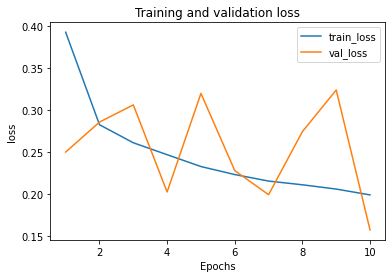

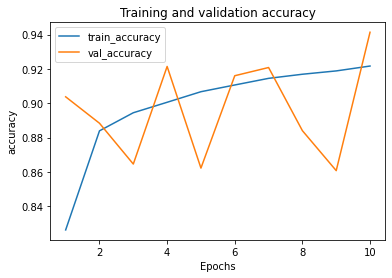

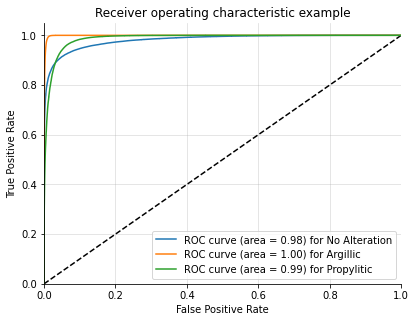

ROC AUC score: 0.9892217170245438



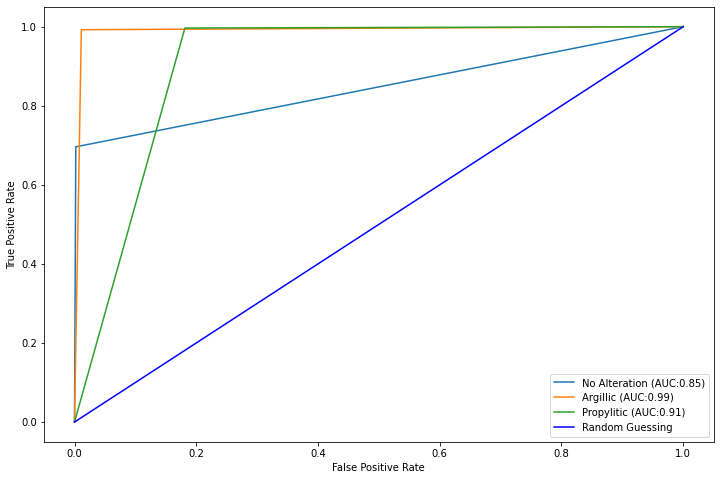

ROC AUC score: 0.9150635885169986

   Accuracy  precision    recall  F1_score     AUC_0     AUC_1     AUC_2  \
0  0.907308   0.910649  0.928700  0.916790  0.917198  0.990707  0.914531   
1  0.935216   0.942388  0.932616  0.937288  0.929447  0.966762  0.947967   
2  0.910660   0.914011  0.930889  0.919984  0.918756  0.991433  0.917728   
3  0.918001   0.939614  0.917471  0.922483  0.881459  0.990918  0.927768   
4  0.935862   0.934307  0.941585  0.936866  0.920543  0.989763  0.949149   
5  0.941393   0.946157  0.945174  0.945216  0.927829  0.990397  0.949158   
6  0.866460   0.917027  0.859184  0.871471  0.809900  0.973619  0.878253   
7  0.940340   0.942508  0.946004  0.943968  0.929024  0.991219  0.948726   
8  0.939855   0.942836  0.945830  0.944305  0.933053  0.988520  0.947280   
9  0.895833   0.927808  0.895019  0.900227  0.847007  0.990558  0.907626   

   Aggregate_AUC  
0       0.940812  
1       0.948058  
2       0.942639  
3       0.933382  
4       0.953152  
5       0.9557

In [ ]:
Model_name = 'MLP_ADAM'
NAME = 'ASTER_DATA'
optimiser_type = 'Adam'
experimental_runs = 10

best_model, best_history, df, avg_y_pred = MLP_model(Model_name, NAME, optimiser_type, experimental_runs)
best_model.save('Best_model_{}_{}'.format(NAME, Model_name))

train_x, train_y, test_x, test_y = get_data(NAME)
label_names = labels_for_datasets(NAME)

plot_metric(best_history, "loss")
print("")
plot_metric(best_history, "accuracy")

plot_avg_AUC_ROC(avg_y_pred, test_y, 3, label_names)
print("")
avg_y_pred = avg_y_pred.argmax(axis=-1)
print('ROC AUC score:', multiclass_roc_auc_score(test_y, avg_y_pred, label_names))

print("")
print(df)
print(df.mean(axis = 0))

Epoch 1/10
11034/11034 [==============================] - 35s 3ms/step - loss: 0.5695 - accuracy: 0.7317 - val_loss: 0.3750 - val_accuracy: 0.8476
Epoch 2/10
11034/11034 [==============================] - 34s 3ms/step - loss: 0.3813 - accuracy: 0.8344 - val_loss: 0.3206 - val_accuracy: 0.8678
Epoch 3/10
11034/11034 [==============================] - 35s 3ms/step - loss: 0.3332 - accuracy: 0.8591 - val_loss: 0.3505 - val_accuracy: 0.8582
Epoch 4/10
11034/11034 [==============================] - 35s 3ms/step - loss: 0.3096 - accuracy: 0.8705 - val_loss: 0.2671 - val_accuracy: 0.8910
Epoch 5/10
11034/11034 [==============================] - 34s 3ms/step - loss: 0.2920 - accuracy: 0.8791 - val_loss: 0.2481 - val_accuracy: 0.9016
Epoch 6/10
11034/11034 [==============================] - 34s 3ms/step - loss: 0.2758 - accuracy: 0.8869 - val_loss: 0.2781 - val_accuracy: 0.8858
Epoch 7/10
11034/11034 [==============================] - 34s 3ms/step - loss: 0.2624 - accuracy: 0.8926 - val_loss: 0

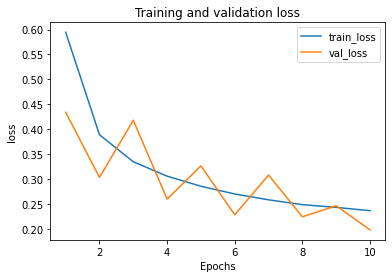

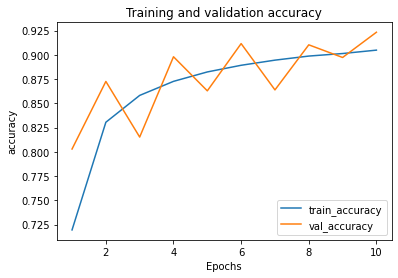

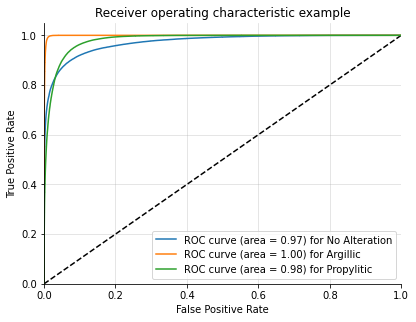

ROC AUC score: 0.9840431461682012



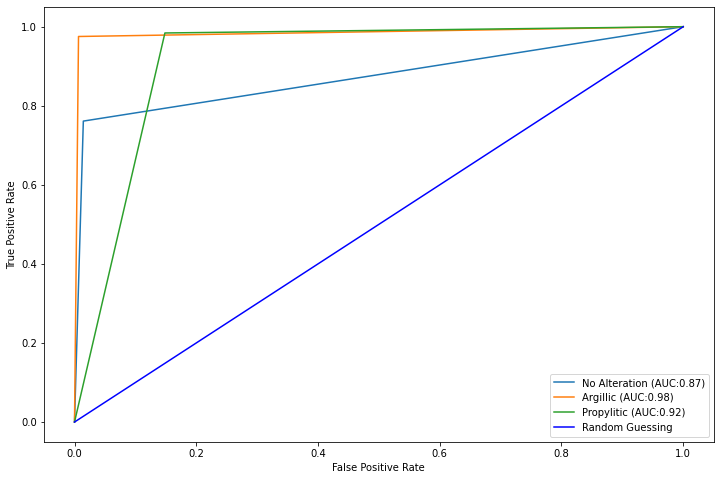

ROC AUC score: 0.9251513672264501

   Accuracy  precision    recall  F1_score     AUC_0     AUC_1     AUC_2  \
0  0.916965   0.932481  0.918742  0.922217  0.887625  0.989187  0.926230   
1  0.923308   0.930376  0.928554  0.928318  0.903692  0.990095  0.932536   
2  0.917305   0.929195  0.920630  0.921811  0.889143  0.990449  0.927758   
3  0.920007   0.933933  0.919408  0.924970  0.898016  0.979667  0.929794   
4  0.909607   0.931113  0.908830  0.915286  0.876240  0.984776  0.919120   
5  0.866392   0.909556  0.866561  0.869292  0.804384  0.990126  0.880706   
6  0.910452   0.912396  0.927361  0.918878  0.911872  0.990316  0.918144   
7  0.921324   0.926164  0.927352  0.925339  0.900902  0.990240  0.932422   
8  0.916429   0.913434  0.928066  0.920029  0.906957  0.988628  0.929218   
9  0.908302   0.931797  0.906836  0.914010  0.873355  0.984314  0.917786   

   Aggregate_AUC  
0       0.934347  
1       0.942108  
2       0.935783  
3       0.935826  
4       0.926712  
5       0.8917

In [ ]:
Model_name = 'MLP_SGD'
NAME = 'ASTER_DATA'
optimiser_type = 'SGD'
experimental_runs = 10

best_model, best_history, df, avg_y_pred = MLP_model(Model_name, NAME, optimiser_type, experimental_runs)
best_model.save('Best_model_{}_{}'.format(NAME, Model_name))

train_x, train_y, test_x, test_y = get_data(NAME)
label_names = labels_for_datasets(NAME)

plot_metric(best_history, "loss")
print("")
plot_metric(best_history, "accuracy")

plot_avg_AUC_ROC(avg_y_pred, test_y, 3, label_names)
print("")
avg_y_pred = avg_y_pred.argmax(axis=-1)
print('ROC AUC score:', multiclass_roc_auc_score(test_y, avg_y_pred, label_names))

print("")
print(df)
print(df.mean(axis = 0))